# Анализ прибыльности подписок

## Описание проекта
Заказчик предоставил данные о некоторых пользователях сервиса аренды самокатов GoFast из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
* без подписки
    * абонентская плата отсутствует;
    * стоимость одной минуты поездки — 8 рублей;
    * стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra
     * абонентская плата — 199 рублей в месяц;
    * стоимость одной минуты поездки — 6 рублей;
    * стоимость старта — бесплатно.

## Описание данных
Пользователи — users_go.csv
* user_id	уникальный идентификатор пользователя
* name	имя пользователя
* age	возраст
* city	город
* subscription_type	тип подписки (free, ultra)

Поездки — rides_go.csv
* user_id	уникальный идентификатор пользователя
* distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
* duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* date	дата совершения поездки

Подписки — subscriptions_go.csv
* subscription_type	тип подписки
* minute_price	стоимость одной минуты поездки по данной подписке
* start_ride_price	стоимость начала поездки
* subscription_fee	стоимость ежемесячного платежа

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

## Предобработка данных

In [2]:
try:
    df_rides = pd.read_csv("rides_go.csv")
    df_subscriptions = pd.read_csv("subscriptions_go.csv")
    df_users = pd.read_csv("users_go.csv")
except:
    df_rides = pd.read_csv("/datasets/rides_go.csv")
    df_subscriptions = pd.read_csv("/datasets/subscriptions_go.csv")
    df_users = pd.read_csv("/datasets/users_go.csv")

**Таблица df_rides**

In [3]:
df_rides.info()
df_rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Проверим наличие дубликатов или пропусков

In [4]:
print("Всего пропусков:\n", df_rides.isna().sum(), sep='')
print("\nВсего дубликатов:", df_rides.duplicated().sum())

Всего пропусков:
user_id     0
distance    0
duration    0
date        0
dtype: int64

Всего дубликатов: 0


Пропусков и дубликатов нет, единственное, что можно сделать - поменять тип столбца date на временной

In [5]:
df_rides['date'] = pd.to_datetime(df_rides['date'])

Посмотрим временной промежуток по годам полученных данных.

In [6]:
print("Данный за года", df_rides['date'].dt.year.unique())

Данный за года [2021]


Все данные за 2021 год, так что можем для последующего анализа добавить только столбец с номером месяца.

In [7]:
df_rides['month'] = df_rides['date'].dt.month

**Таблица df_subscriptions**

In [8]:
df_subscriptions.info()
df_subscriptions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Таблица очень маленькая и менять здесь нечего

**Таблица df_users**

In [9]:
df_users.info()
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


Проверим наличие дубликатов и пропусков

In [10]:
print("Всего пропусков:\n", df_users.isna().sum(), sep='')
print("\nВсего дубликатов:", df_users.duplicated().sum())

Всего пропусков:
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Всего дубликатов: 31


Удалим найденные дубликаты

In [11]:
df_users = df_users.drop_duplicates()

In [12]:
df_users["age"].value_counts().sort_index(ascending=False)

43      1
39      1
38      3
37      2
36      6
35     15
34     19
33     39
32     41
31     48
30     68
29     68
28    112
27    119
26    131
25    145
24    132
23    129
22    119
21     93
20     71
19     47
18     46
17     26
16     19
15     13
14      9
13      8
12      4
Name: age, dtype: int64

### Промежуточный вывод по предобработке данных
При предобработке в таблице df_rides был изменён тип столбца с датой на временной, добавлен новый столбец с номером месяца совершённой поездки и удалены возможные выбросы. Из таблицы df_users были удалены явные дубликаты.

## Исследовательский анализ данных
Изучим основную информаци представленную в таблицах, такую как частота встречаемости городов, соотношение пользователей с подпиской и без подписки, возраст пользователей, расстояние, которое пользователь преодолел за одну поездку, продолжительность поездок.

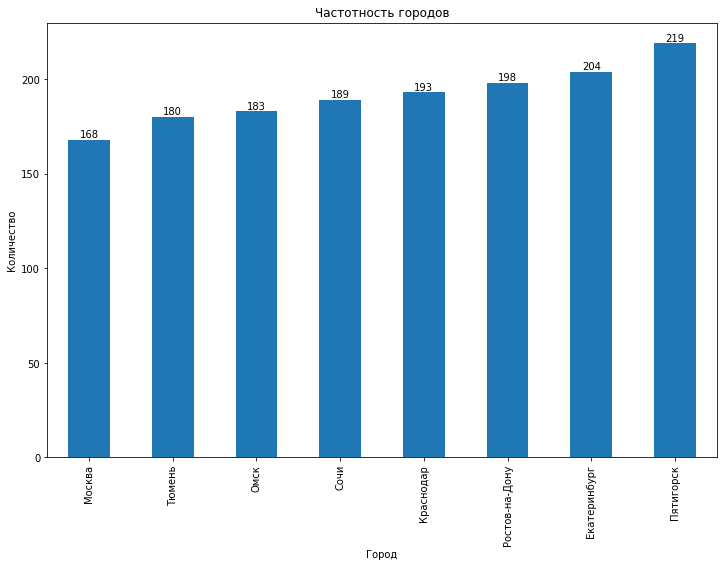

In [13]:
city_freq = df_users["city"].value_counts(ascending=True)
city_freq.plot(kind="bar", figsize=(12, 8));
# Добавление числовых значений над столбцами
for i, value in enumerate(city_freq):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')
plt.title("Частотность городов")
plt.xlabel("Город")
plt.ylabel("Количество")
plt.show()

Как видно большинство пользователей из Пятигорска, Екатеринбурга и Ростова-на-Дону, наименьшее же количество в городах Москва, Тюмень и Омск.

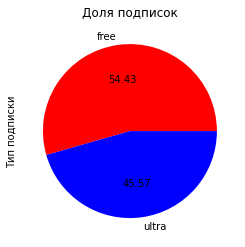

In [14]:
df_users["subscription_type"].value_counts().plot.pie(autopct="%.2f", colors=["r", "b"]);
plt.title("Доля подписок")
plt.ylabel("Тип подписки")
plt.show()

Больше половины людей, а именно 54.43% не пользуются подпиской. Пользователей с подпиской Ultra - 45.57%

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


Text(0, 0.5, 'Количество')

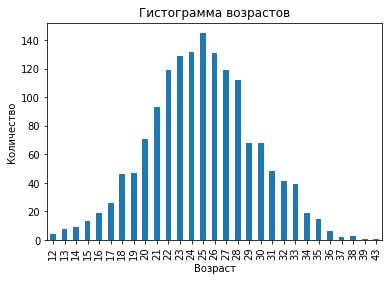

In [15]:
print(df_users["age"].describe())
df_users["age"].value_counts().sort_index().plot(kind='bar');
plt.title("Гистограмма возрастов")
plt.xlabel("Возраст")
plt.ylabel("Количество")

Распределение возраста похоже на нормальное с мат ожиданием в 25. Среднее и медиана практически равны 25, стандартное отклонение 4,5 года. Минимальный возраст 12 лет, максимальный 43. 50% всех значений лежат в промежутке от 22 до 28 лет.

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64


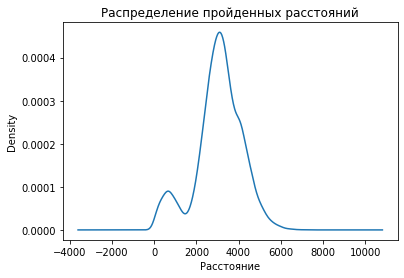

In [16]:
print(df_rides['distance'].describe())
df_rides['distance'].plot(kind='kde');
plt.title("Распределение пройденных расстояний")
plt.xlabel("Расстояние")
plt.show()

Распределение похожее на нормальное с небольшим пиком в районе 1000м. Среднее примерно равно медиане и примерно равно 3170, стандартное отклонение 920м.  Максимальная дистанция равна 5623м, минимальная 694м. 50% всех значений лежат в промежутке 2635-3777.

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64


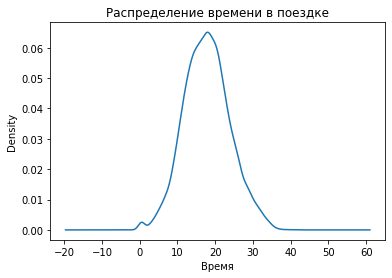

In [17]:
print(df_rides['duration'].describe())
df_rides['duration'].plot(kind='kde');
plt.title("Распределение времени в поездке")
plt.xlabel("Время")
plt.show()

Распределение похожее на нормальное. Среднее и медиана примерно равны 18мин, стандартное отклонение 4,5 минуты. Максимальная продолжительность поездки - 33,5 минут, минимальная 3,5. 50% всех наблюдений расположены в промежутке от 14 до 22 минут.

### Промежуточный вывод по исследовательскому анализу
В ходе исследовательского анализа данных было выяснено следующее:
* Большинство пользователей из Пятигорска, Екатеринбурга и Ростова-на-Дону, наименьшее же количество в городах Москва, Тюмень и Омск.
* Больше половины людей, а именно 54.43% не пользуются подпиской. Пользователей с подпиской Ultra - 45.57%
* Возраст распределён почти нормально. Среднее и медиана практически равны 25, стандартное отклонение 4,5 года. Минимальный возраст 12 лет, максимальный 43. 50% всех значений лежат в промежутке от 22 до 28 лет.
* Распределение пройдённого расстояния похоже на нормальное с небольшим пиком в районе 1000м. Среднее примерно равно медиане и примерно равно 3170, стандартное отклонение 920м.  Максимальная дистанция равна 5623м, минимальная 694м. 50% всех значений лежат в промежутке 2635-3777.
* Распределение затраченного га поездку времени похоже на нормальное. Среднее и медиана примерно равны 18мин, стандартное отклонение 4,5 минуты. Максимальная продолжительность поездки - 33,5 минут, минимальная 3,5. 50% всех наблюдений расположены в промежутке от 14 до 22 минут.

## Объединение данных
Объединим все данные в один датафрейм

In [18]:
df_combined = df_rides.merge(df_users)
df_combined = df_combined.merge(df_subscriptions)
df_combined.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Рассмотрим получившийся dataframe

In [19]:
print("Размерность объединенного датафрейма:", df_combined.shape)

# Проверка наличия пропусков
print("Пропуски в объединенном датафрейме:")
print(df_combined.isnull().sum())

Размерность объединенного датафрейма: (18068, 12)
Пропуски в объединенном датафрейме:
user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Создадим ещё 2 таблицы с данными о поездках по подписке и по бесплатному тарифу

In [20]:
df_subscription_free = df_combined[df_combined['subscription_type'] == 'free'].reset_index(drop=True)
df_subscription_free

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
1,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
2,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
3,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
4,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11563,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
11564,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
11565,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
11566,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


In [21]:
df_subscription_ultra = df_combined[df_combined['subscription_type'] == 'ultra']
df_subscription_ultra

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,3973.046497,24.671163,2021-08-29,8,Оксана,22,Москва,ultra,6,0,199
6496,699,3288.702563,15.892886,2021-09-12,9,Оксана,22,Москва,ultra,6,0,199
6497,699,3076.159348,14.389525,2021-09-26,9,Оксана,22,Москва,ultra,6,0,199
6498,699,4707.845501,15.839579,2021-10-17,10,Оксана,22,Москва,ultra,6,0,199


Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

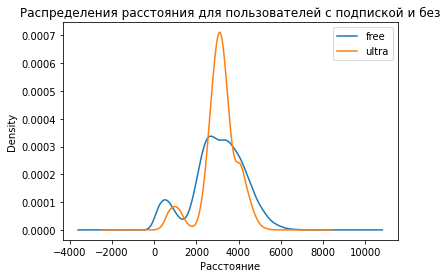

In [22]:
distance_free = df_subscription_free['distance']
distance_ultra = df_subscription_ultra['distance']

distance_free.plot(kind='kde', label='free')
distance_ultra.plot(kind='kde', label='ultra')
plt.title("Распределения расстояния для пользователей с подпиской и без")
plt.xlabel("Расстояние")
plt.legend()
plt.show()

In [23]:
print('FREE\n', distance_free.describe())
print('ULTRA\n', distance_ultra.describe())

FREE
 count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64
ULTRA
 count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64


Распределения оба нормальные, но отличаются по своим параметрам, у подписки ultra грaфик более остроконечен, для более точной оценки нужно провести статистические тесты. Медианы и средние у них примерно равны, но сильно отличаются стандартные отклонения.

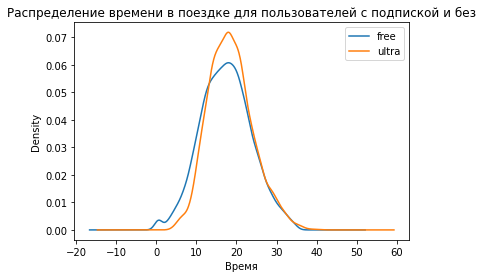

In [24]:
duration_free = df_subscription_free['duration']
duration_ultra = df_subscription_ultra['duration']

duration_free.plot(kind='kde', label='free')
duration_ultra.plot(kind='kde', label='ultra')

plt.title("Распределение времени в поездке для пользователей с подпиской и без")
plt.xlabel("Время")

plt.legend()
plt.show()

In [25]:
print('FREE\n', duration_free.describe())
print('ULTRA\n', duration_ultra.describe())

FREE
 count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64
ULTRA
 count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64


Значимых различий по графикам не видно, для более точной оценки нужно провести статистические тесты.

## Подсчёт выручки

Составим агрегированную таблиц с посчитанным  суммарным расстоянием, количеством поездок и суммарным временем для каждого пользователя за каждый месяц.

In [26]:
df_combined['duration'] = np.ceil(df_combined['duration'])
pivot_table_rides = (df_combined.pivot_table(values=['distance', 'duration', 'subscription_type'],
                                             index=['user_id', 'month'],
                                             aggfunc={'distance': 'sum', 'duration':['sum', 'count'], 'subscription_type' : 'first'})
                      .reset_index())

pivot_table_rides.columns = ['user_id', 'month', 'total_distance', 'rides_count',  'total_duration', 'subscription_type']
pivot_table_rides

,user_id,month,total_distance,rides_count,total_duration,subscription_type
0,1,1,7027.511294,2,42.0,ultra
1,1,4,754.159807,1,7.0,ultra
2,1,8,6723.470560,2,46.0,ultra
3,1,10,5809.911100,2,32.0,ultra
4,1,11,7003.499363,3,56.0,ultra
...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0,free
11327,1534,8,7622.453034,2,48.0,free
11328,1534,9,4928.173852,1,23.0,free
11329,1534,11,13350.015305,4,78.0,free


Добавим в таблицу столбцы с данными подписке для удобства дальнейших расчётов

In [27]:
pivot_table_rides = pivot_table_rides.merge(df_subscriptions, on='subscription_type', how='left')
pivot_table_rides

,user_id,month,total_distance,rides_count,total_duration,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511294,2,42.0,ultra,6,0,199
1,1,4,754.159807,1,7.0,ultra,6,0,199
2,1,8,6723.470560,2,46.0,ultra,6,0,199
3,1,10,5809.911100,2,32.0,ultra,6,0,199
4,1,11,7003.499363,3,56.0,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0,free,8,50,0
11327,1534,8,7622.453034,2,48.0,free,8,50,0
11328,1534,9,4928.173852,1,23.0,free,8,50,0
11329,1534,11,13350.015305,4,78.0,free,8,50,0


Посмотрим не образовались ли какие-либо пропуски.

In [28]:
pivot_table_rides.isna().sum()

user_id              0
month                0
total_distance       0
rides_count          0
total_duration       0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Создадим в таблице отдельный столбец с выручкой за каждый месяц по каждому пользователю

In [29]:
pivot_table_rides['revenue'] = pivot_table_rides['total_duration'] * pivot_table_rides['minute_price'] + pivot_table_rides['rides_count'] * pivot_table_rides['start_ride_price'] + pivot_table_rides['subscription_fee']
pivot_table_rides

,user_id,month,total_distance,rides_count,total_duration,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,7027.511294,2,42.0,ultra,6,0,199,451.0
1,1,4,754.159807,1,7.0,ultra,6,0,199,241.0
2,1,8,6723.470560,2,46.0,ultra,6,0,199,475.0
3,1,10,5809.911100,2,32.0,ultra,6,0,199,391.0
4,1,11,7003.499363,3,56.0,ultra,6,0,199,535.0
...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0,free,8,50,0,308.0
11327,1534,8,7622.453034,2,48.0,free,8,50,0,484.0
11328,1534,9,4928.173852,1,23.0,free,8,50,0,234.0
11329,1534,11,13350.015305,4,78.0,free,8,50,0,824.0


Посмотрим как распределена выручка в зависимости от тарифов.

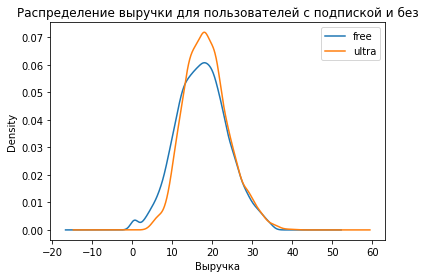

In [30]:
pivot_table_rides_free = pivot_table_rides[pivot_table_rides["subscription_type"] == 'free']
pivot_table_rides_ultra = pivot_table_rides[pivot_table_rides["subscription_type"] == 'ultra']

revenue_free = pivot_table_rides_free['revenue']
revenue_ultra = pivot_table_rides_ultra['revenue']

duration_free.plot(kind='kde', label='free')
duration_ultra.plot(kind='kde', label='ultra')

plt.title("Распределение выручки для пользователей с подпиской и без")
plt.xlabel("Выручка")

plt.legend()
plt.show()

In [31]:
print('FREE\n', revenue_free.describe())
print('ULTRA\n', revenue_ultra.describe())

FREE
 count    6798.000000
mean      328.641365
std       183.868330
min        58.000000
25%       194.000000
50%       274.000000
75%       428.000000
max      1444.000000
Name: revenue, dtype: float64
ULTRA
 count    4533.000000
mean      362.792191
std        88.262737
min       223.000000
25%       301.000000
50%       337.000000
75%       409.000000
max       955.000000
Name: revenue, dtype: float64


По графикам уже видно, что распределение выручки для пользователей с подпиской смещено вправо относительно пользователей без подписки. Это подверждают и численные характеристики распределений - медиана выручки с подпиской = 337, что сильно больше медины без подписки = 274. Также можно заметить, что пользователи с подпиской по выручке более однородны - стандартное отклонение 88, против 183 у пользователей без подписки. В целов уже видно, что выручки подписка приносит больше, но точное подтвердить это помогут статестические тесты.

In [40]:
pivot_table_rides

,user_id,month,total_distance,rides_count,total_duration,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,7027.511294,2,42.0,ultra,6,0,199,451.0
1,1,4,754.159807,1,7.0,ultra,6,0,199,241.0
2,1,8,6723.470560,2,46.0,ultra,6,0,199,475.0
3,1,10,5809.911100,2,32.0,ultra,6,0,199,391.0
4,1,11,7003.499363,3,56.0,ultra,6,0,199,535.0
...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0,free,8,50,0,308.0
11327,1534,8,7622.453034,2,48.0,free,8,50,0,484.0
11328,1534,9,4928.173852,1,23.0,free,8,50,0,234.0
11329,1534,11,13350.015305,4,78.0,free,8,50,0,824.0


## Проверка гипотез
Для всех гипотез выберем уровень значимости alpha = 0.05

In [32]:
alpha = 0.05

Важно понять, тратят ли пользователи с подпиской больше времени на поездки:
* Нулевая гипотеза H0 - среднее время поездок с подпиской и без равно
* Альтернативная гипотеза H1 - среднее время поездок пользователей с подпиской больше, чем у пользователей без подписки

In [33]:
results = st.ttest_ind(df_subscription_ultra['duration'], df_subscription_free['duration'], alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось нулевую отвергнуть гипотезу') 

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской проводят больше времени в поездках.

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров:
* Нулевая гипотеза H0 - Среднее расстояние пользователей с подпиской за одну поездку равно 3130 метров
* Альтернативная гипотеза H1 - Среднее расстояние пользователей с подпиской за одну поездку превышает 3130 метров

In [34]:
results = st.ttest_1samp(df_subscription_ultra['distance'], 3130, alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось нулевую отвергнуть гипотезу') 

p-значение: 0.9195368847849785
Не получилось нулевую отвергнуть гипотезу


Полученное значение p-value больше заданного уровня значимости, поэтому нельзя отвергнуть нулевую гипотезу. Мы не можем утверждать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.Из этого следует, что среднее расстояние, преодолеваемое на самокате в одной поездке, не обязательно является оптимальным для износа.

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 
* Нулевая гипотеза H0 - Помесячные выручки от пользователей с подпиской и без равны
* Альтернативная гипотеза H1 - Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки


In [35]:
pivot_table_rides_ultra = pivot_table_rides[pivot_table_rides["subscription_type"] == 'ultra']
pivot_table_rides_free = pivot_table_rides[pivot_table_rides["subscription_type"] == 'free']

results = st.ttest_ind(pivot_table_rides_ultra['revenue'], pivot_table_rides_free['revenue'], alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось нулевую отвергнуть гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить о том, что пользователи с подпиской приносят больший доход.

 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?
    
T-тест для двух зависимых выборок, а именно scipy.stats.ttest_rel(alternative='less')

### Промежуточный вывод по по проверке гипотез
При проверке гипотез были получены следующие выводы:
* Есть основания говорить, что пользователи с подпиской проводят больше времени в поездках.
* Мы не можем утверждать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров
* Есть основания говорить о том, что пользователи с подпиской приносят больший доход.


## Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Произошедшую ситуацию можно описать с помощью модели биномиального распределения, с p = 0.1 и n которое надо найти. Задачу можно переформулировать так: при каком минимальном n в биномиальном распределении вероятность 99 или менее неудачи будет 5% при том, что вероятность успеха 10%.

In [36]:
p_success = 0.1  # вероятность продления подписки
target_failure = 99
failure_probability = 0.05  
n = 100
distr = st.binom(n, p_success)
while distr.cdf(target_failure) > failure_probability:
    n += 1
    distr = st.binom(n, p_success)
print("Минимальное n =", n)

Минимальное n = 1161


Построим график распределения с наиболее встречающимися значениями.

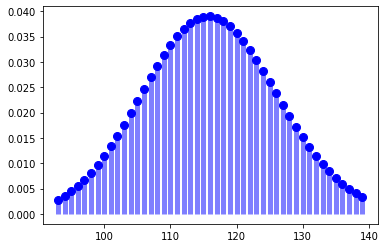

In [37]:
fig, ax = plt.subplots(1, 1)
x = np.arange(st.binom.ppf(0.01, n, p_success),
              st.binom.ppf(0.99, n, p_success))
ax.plot(x, st.binom.pmf(x, n, p_success), 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, st.binom.pmf(x, n, p_success), colors='b', lw=5, alpha=0.5);

Отделу маркетинга необходимо раздать как минимум 1161 промокод

7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

В данной задаче мы хоти аппроксимировать биномиальное распределение к нормальному. Для хорошей аппроксимации необходимо, чтобы промежуток от математического ожидания биномиального распределения плюс-минус три его стандартных отклонения лежал в пределах [0,n], проверим это. Распределение - B(1000000, 0,4), E = n*p = 400000, 
sd = sqrt(n*p*(1-p)) = 490. Как видим мы можем провести хорошую аппроксимацию с помошью распределения 
N(400000, 490).


Построим график этого распределения

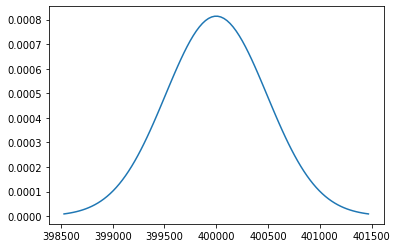

In [38]:
E = 400000
sd = 490
x = np.linspace(E - 3*sd, E + 3*sd, 100)
plt.plot(x, st.norm.pdf(x, E, sd))
plt.show()

Оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [39]:
print(f"Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей = {st.norm.cdf(399500, E, sd):.2%}")

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей = 15.38%


## Общий вывод

 В ходе работы была провдена предобработка, исследовательский анализ данных и проверка некоторых гипотез. 
 
При предобработке в таблице rides_go.csv был изменён тип столбца с датой на временной, добавлен новый столбец с номером месяца совершённой поездки и удалены возможные выбросы. Из таблицы users_go.csv были удалены явные дубликаты.

В ходе исследовательского анализа было выяснено следующее:
   * Большинство пользователей из Пятигорска, Екатеринбурга и Ростова-на-Дону, наименьшее же количество в городах Москва, Тюмень и Омск.
   * Больше половины людей, а именно 54.43% не пользуются подпиской. Пользователей с подпиской Ultra - 45.57%
   * Возраст распределён почти нормально. Среднее и медиана практически равны 25, стандартное отклонение 4,5 года. Минимальный возраст 12 лет, максимальный 43. 50% всех значений лежат в промежутке от 22 до 28 лет.
   * Распределение пройдённого расстояния похоже на нормальное с небольшим пиком в районе 1000м. Среднее примерно равно медиане и примерно равно 3170, стандартное отклонение 920м.  Максимальная дистанция равна 5623м, минимальная 694м. 50% всех значений лежат в промежутке 2635-3777.
   * Распределение затраченного на поездку времени похоже на нормальное. Среднее и медиана примерно равны 18мин, стандартное отклонение 4,5 минуты. Максимальная продолжительность поездки - 33,5 минут, минимальная 3,5. 50% всех наблюдений расположены в промежутке от 14 до 22 минут.
     
При проверке гипотез были получены следующие выводы:
   * Есть основания говорить, что пользователи с подпиской проводят больше времени в поездках.
   * Мы не можем утверждать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров
   * Есть основания говорить о том, что пользователи с подпиской приносят больший доход.
   
Также в ходе работы было отвечено на несколько вопросов маркетологов:
* Отделу маркетинга в ходе акции необходимо раздать как минимум 1161 промокод, для того чтобы как минимум 100 пользователей решило продлить подписку
* Если отдел маркетинга планирует разослать 1 млн уведомлений, то его откроют не более 399,5 тыс. пользователей с вероятность около 15%.

Итак, исследование показало, что пользователи с подпиской не только проводят в поездках больше времени, но и в целом приносят большую выручку(медиана 337 рублей в месяц, против 274 у пользователей без подписки). Можно считать что пользователи с подпиской для компании выгоднее.